In [3]:
%matplotlib inline

import os
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.basemap import Basemap

import netCDF4 as nc

from six.moves import urllib # six is for Python 2/3 compatibility

from pycurrents.codas import to_day
from pycurrents.num import rangeslice
from pycurrents.num import eof
# https://currents.soest.hawaii.edu/ocn_data_analysis/installation.html

In [4]:
sstnc  = nc.Dataset('sst_yrmean_1951_2124_remap_ind.nc')
tauxnc = nc.Dataset('esm_pi_taux_1951_2124_ind.nc')
tauync = nc.Dataset('esm_pi_tauy_1951_2124_ind.nc')

time = sstnc.variables['time'][:]
lat = sstnc.variables['lat'][:]                       
lon = sstnc.variables['lon'][:]
sst = sstnc.variables['SST'][:]
taux = tauxnc.variables['TAUX'][:]
tauy = tauync.variables['TAUY'][:]

lsmasknc = nc.Dataset('lsmask_regrid.nc')
seamask = lsmasknc.variables['mask'][0].astype(bool)

lsmasknc.close()
sstnc.close()
landmask = np.logical_not(seamask)
#print(landmask.shape)
sst[:, landmask] = np.ma.masked
taux[:, landmask] = np.ma.masked
tauy[:, landmask] = np.ma.masked

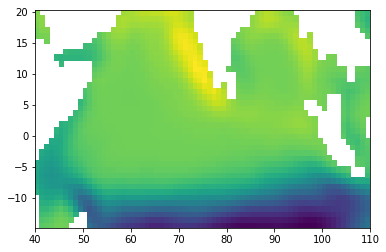

In [5]:
plt.pcolormesh(lon, lat, taux[5])

In [6]:
sstmean = sst.mean(axis=0)
sstdm = sst - sstmean

sstdmz = sstdm.filled(0)

tauxmean = taux.mean(axis=0)
tauxdm = taux - tauxmean

tauxdmz = tauxdm.filled(0)

tauymean = tauy.mean(axis=0)
tauydm = tauy - tauymean

tauydmz = tauydm.filled(0)


In [7]:
latweights = np.sqrt(np.cos(np.deg2rad(lat)))
latweights = latweights[np.newaxis, :, np.newaxis]
sstdmz *= latweights
tauxdmz *= latweights
tauydmz *= latweights
X = np.zeros((sstdmz.shape[0]*3, sstdmz.shape[1]*sstdmz.shape[2]))
X[0:sstdmz.shape[0], :] = np.reshape(sstdmz, (sstdmz.shape[0], sstdmz.shape[1]*sstdmz.shape[2]))
X[sstdmz.shape[0]:sstdmz.shape[0]*2, :] = np.reshape(tauxdmz, (sstdmz.shape[0], sstdmz.shape[1]*sstdmz.shape[2]))
X[sstdmz.shape[0]*2:sstdmz.shape[0]*3, :] = np.reshape(sstdmz, (sstdmz.shape[0], sstdmz.shape[1]*sstdmz.shape[2]))

In [8]:
ssteof = eof.EOF(X)

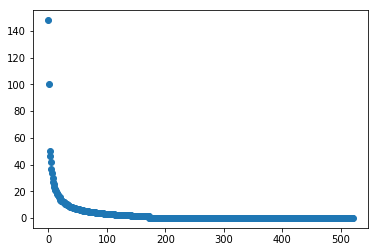

In [9]:
fig, ax = plt.subplots()
ax.plot(ssteof.s, 'o')
ax.margins(0.05)


In [10]:
yeartime = 1556 + time 
print(yeartime[0], yeartime[-1])

1951.005376344086 2124.008064516129


[42.88364039 19.82826416  4.94134672  4.2082574   3.38813633  2.66760304
  2.18102001  1.70817842  1.45033703  1.29471852]


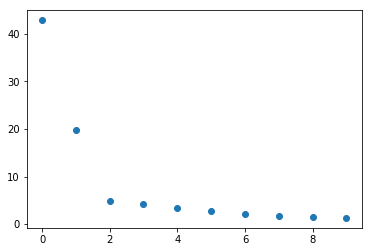

In [11]:
fig, ax = plt.subplots()
ax.plot(ssteof.percent_var()[:10], 'o')
print(ssteof.percent_var()[:10])
plt.savefig('combined_variance_explained.png')

In [12]:
#fig, ax = plt.subplots()
#ax.plot(yeartime, ssteof.u[:, 5:7])
eof_dummy = ssteof.v_reshaped[0:174].flatten()
combined_eof = np.reshape(eof_dummy, (sstdmz.shape[0], sstdmz.shape[1], sstdmz.shape[2]))
#combined_eof.shape
ssteof.u.shape

(522, 522)

In [13]:
pats = np.ma.array(combined_eof)
pats[:, landmask] = np.ma.masked
pats /= latweights
pats = pats *  ssteof.s[0:174, np.newaxis, np.newaxis]

In [14]:
cmap = plt.get_cmap('RdBu_r')

In [15]:
# quick and dirty: using global pats and ssteof
def contour_pattern(i):
    # normalize so that std of time function is unity, and pattern
    # is in degrees.
    std_t = ssteof.u[0:174, i].std()
    pat = pats[i] * std_t
    mag = pat.std()
    cticker = mpl.ticker.MaxNLocator(nbins=30, symmetric=True)
    cticker.create_dummy_axis()
    cticker.set_bounds(-2*mag, 2*mag)
    clevs = cticker()

    fig, ax = plt.subplots()
    cs = ax.contourf(lon, lat, pat, levels=clevs,
                 cmap=cmap,
                 extend='both')
    ax.patch.set_facecolor('gray')
    fig.colorbar(cs, ax=ax, shrink=2.0)

In [ ]:
contour_pattern(0)
plt.title(np.around(ssteof.percent_var()[0]))
plt.savefig('combined_eof1.png')

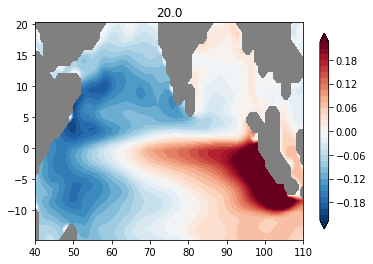

In [68]:
contour_pattern(1)
plt.title(np.around(ssteof.percent_var()[1]))
plt.savefig('combined_eof2.png')

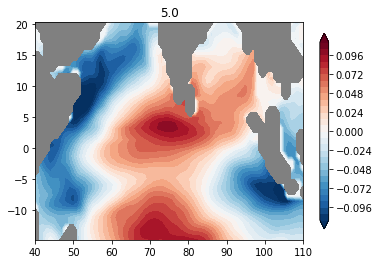

In [71]:
contour_pattern(2)
plt.title(np.around(ssteof.percent_var()[2]))
plt.savefig('combined_eof3.png')

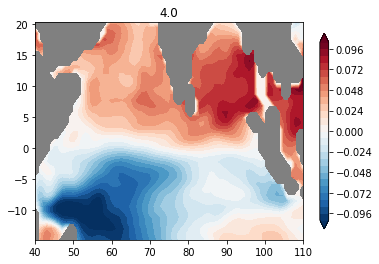

In [72]:
contour_pattern(3)
plt.title(np.around(ssteof.percent_var()[3]))
plt.savefig('combined_eof4.png')